# Si quiero usar tf 2.0 lo mejor que puedo hacer es from tensorflow.keras import ... (los mismos imports). Esto es porque tf tiene mejor integracion con keras. Aunque la verdad me parece que rinde mas para proyectos que van a ser mas largos, para esto no se si rinde.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Model
from keras import backend as K
from sklearn.model_selection import train_test_split

Using CNTK backend
C:\Users\ing_l\Anaconda3\envs\new_environment\lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
############################################################################################################################################

  warnings.warn(WARNING_MSG_GPU_ONLY % ('GPU-Specific', 'https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu

In [2]:
#Just for monitoring
import wandb
from wandb.keras import WandbCallback
wandb.init(project="cnn-so")

W&B Run: https://app.wandb.ai/lucholomas/uncategorized/runs/hyfe3p9i

In [3]:
#C:\Users\ing_l\Final SO\Breast Cancer

In [4]:
#The data is stores as ints

In [5]:
data = np.load(r'C:\Users\ing_l\Final SO\Breast Cancer\X.npy')

In [6]:
targets = np.load(r'C:\Users\ing_l\Final SO\Breast Cancer\Y.npy')

In [7]:
print(data.shape)
print(targets.shape)
print(len(data[targets == 0]))
print(len(data[targets == 1]))

(5547, 50, 50, 3)
(5547,)
2759
2788


In [8]:
data, targets = shuffle(data, targets)

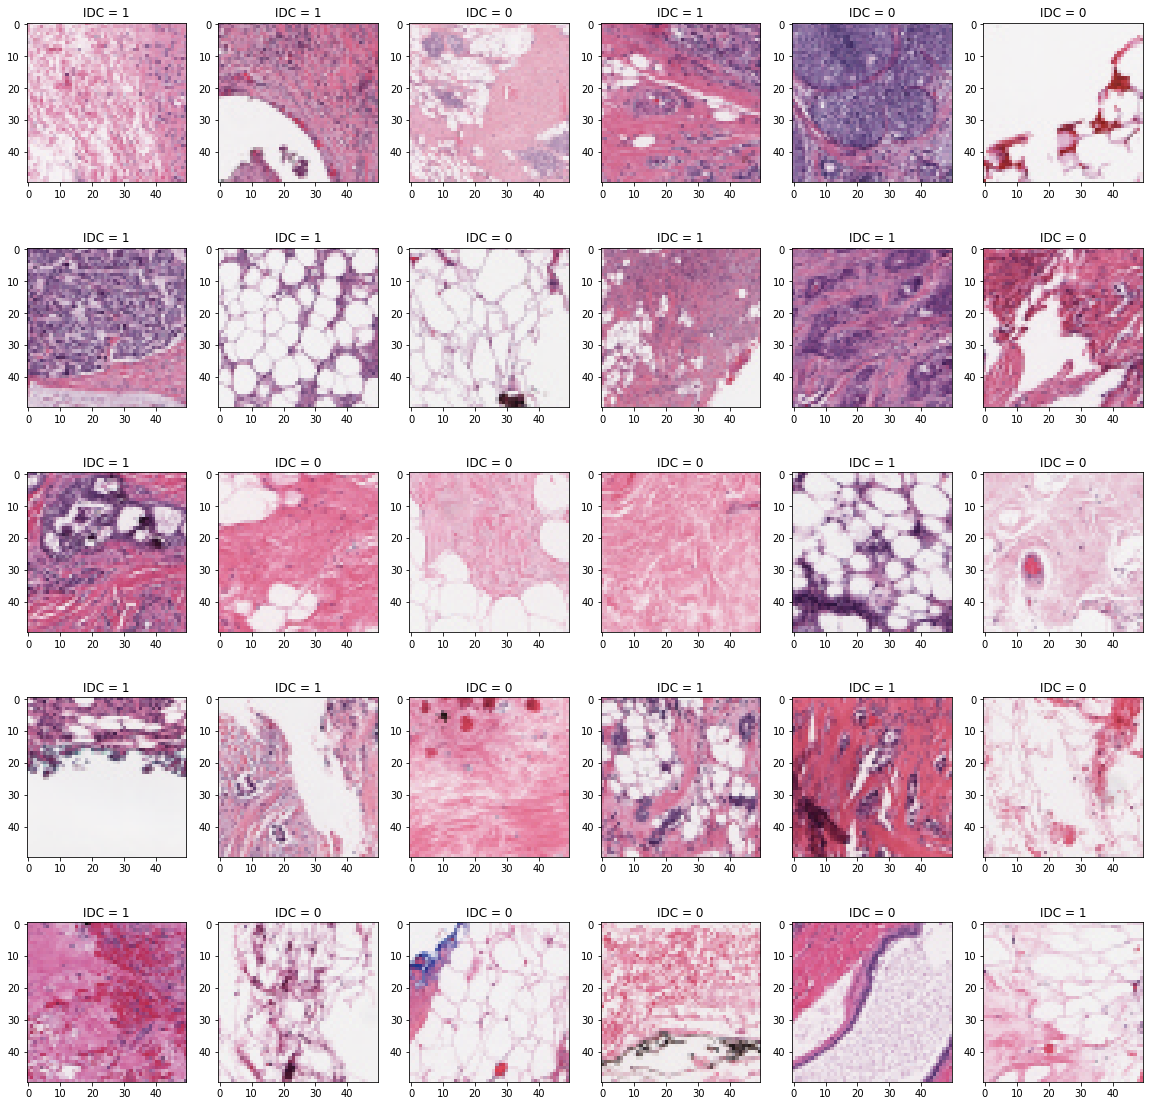

In [9]:
# plot some images  

imgs_0 = data[targets == 0] # 0 = no cancer
imgs_1 = data[targets == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%targets[i])
    plt.imshow(data[i])

red channel: min/mean/std/max = 4.00/205.79/36.29/255.00
green channel: min/mean/std/max = 2.00/161.87/53.94/255.00
blue channel: min/mean/std/max = 5.00/187.44/38.69/255.00


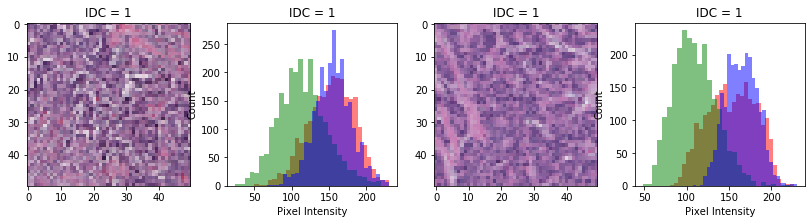

In [10]:
plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(data))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%targets[n_img])
    plt.imshow(data[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%targets[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(data[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(data[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(data[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);

print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(data[:,:,:,0].min(),
    data[:,:,:,0].mean(), data[:,:,:,0].std(), data[:,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(data[:,:,:,1].min(),
    data[:,:,:,1].mean(), data[:,:,:,1].std(), data[:,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(data[:,:,:,2].min(),
    data[:,:,:,2].mean(), data[:,:,:,2].std(), data[:,:,:,2].max()))

In [11]:
#Normalize data and categorize targets
data = data / 255.0

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, stratify=targets)

In [13]:
#Starting model

i = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
d = Conv2D(10, (3, 3), activation='relu')(i)
d = BatchNormalization()(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(20, (3, 3), activation='relu')(d)
d = Conv2D(40, (5, 5), activation='relu')(d)
d = BatchNormalization()(d)
d = Conv2D(50, (3, 3), activation='relu')(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(50, (5, 5), activation='relu')(d)
d = Flatten()(d)
d = Dropout(0.5)(d)
d = Dense(100, activation='relu')(d)
d = Dense(1, activation='sigmoid')(d)

model = Model(inputs=i, outputs=d)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['binary_accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 10)        280       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 10)        40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 20)        1820      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 40)        20040     
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 40)        160 

In [14]:
h = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_test, y_test), callbacks=[WandbCallback()])

Train on 4437 samples, validate on 1110 samples
Epoch 1/20


C:\Users\ing_l\Anaconda3\envs\new_environment\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input4") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


4437/4437 [==============================] - 303s 68ms/step - loss: 0.6237 - binary_accuracy: 0.7588 - val_loss: 0.6243 - val_binary_accuracy: 0.5978
Epoch 2/20
4437/4437 [==============================] - 346s 78ms/step - loss: 0.5652 - binary_accuracy: 0.7769 - val_loss: 0.7652 - val_binary_accuracy: 0.5870
Epoch 3/20
4437/4437 [==============================] - 337s 76ms/step - loss: 0.5644 - binary_accuracy: 0.7816 - val_loss: 0.9598 - val_binary_accuracy: 0.6178
Epoch 4/20
4437/4437 [==============================] - 251s 57ms/step - loss: 0.5317 - binary_accuracy: 0.7850 - val_loss: 0.5641 - val_binary_accuracy: 0.7500
Epoch 5/20
4437/4437 [==============================] - 311s 70ms/step - loss: 0.5294 - binary_accuracy: 0.7890 - val_loss: 0.5554 - val_binary_accuracy: 0.7409
Epoch 6/20
4437/4437 [==============================] - 349s 79ms/step - loss: 0.5189 - binary_accuracy: 0.7908 - val_loss: 0.5934 - val_binary_accuracy: 0.7183
Epoch 7/20
4437/4437 [=======================

SystemError: <built-in function Function__forward> returned a result with an error set

In [ ]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['binary_accuracy'])
plt.plot(h.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
'''#Starting model
i = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
d = Flatten()(i)
d = Dense(512, activation='relu')(d)
d = Dense(1024, activation='relu')(d)
d = Dropout(0.2)(d)
d = Dense(2048, activation='relu')(d)
d = Dropout(0.3)(d)
d = Dense(5000, activation='relu')(d)
d = Dense(5000, activation='relu')(d)
d = Dropout(0.4)(d)
d = Dense(5000, activation='relu')(d)
d = Dropout(0.5)(d)
d = Dense(1024, activation='relu')(d)
d = Dropout(0.5)(d)
d = Dense(1, activation='sigmoid')(d)
model = Model(inputs=i, outputs=d)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])'''

In [ ]:
'''h = model.fit(x_train, y_train, batch_size=16, epochs=30, validation_data=(x_test, y_test))'''

In [ ]:
'''%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['binary_accuracy'])
plt.plot(h.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()'''